First on the agenda: connect this notebook to Google Drive.

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")



CUDA is available. Using GPU: Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# The Data

I've queried all available records of WSE for all residential and irrigation wells in Fresno county from 1970 to the present day. Interestingly though, as shown below, the earliest measurement date for any well is **well before 1970**. This is perhaps because on the website, 1970 was the minimum query year for some reason, and the site took this to mean that I needed data from as early back as possible.

This is a moderately sizeable dataset with over 30000 records, and it's the data we'll be using for the timeseries analysis. Now to import everything we'll need and load the data into a pandas dataframe:

In [ ]:
pip install torch torchvision torchaudio

In [ ]:
import pandas as pd
import numpy as np

import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

In [ ]:
data_dir = 'drive/MyDrive/FresnoCountyWells/Query_Result_427035502073006'

In [ ]:
df = pd.read_csv(data_dir + '/GroundwaterElevationFresno.csv')

In [ ]:
df

,SITE_CODE,WELL_NAME,SWN,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,...,WLM_ORG_ID,WLM_ORG_NAME,WLM_DESC,WLM_ACC_CODE,WLM_ACC_DESC,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER
0,367217N1204327W001,14S/14E-10P01,14S14E10P001M,14930,11/14/2011 10:48,116.50,100.00,100.00,216.50,216.50,...,5100,Westlands Water District,Acoustic or sonic sounder,1 Ft,Water level accuracy to nearest foot,NaN,NaN,NaN,11/03/2017 18:02,dloyd@westlandswater.org
1,367214N1204143W001,14S/14E-11Q01,14S14E11Q001M,14932,11/14/2011 09:15,NaN,NaN,NaN,200.50,200.50,...,5100,Westlands Water District,NaN,NaN,NaN,7,Special/Other,Unknown problem,11/03/2017 18:02,dloyd@westlandswater.org
2,367082N1204234W001,14S/14E-14N05,14S14E14N005M,46763,11/14/2011 10:55,37.50,178.00,178.00,215.50,215.50,...,5100,Westlands Water District,Acoustic or sonic sounder,1 Ft,Water level accuracy to nearest foot,NaN,NaN,NaN,07/23/2021 16:39,dloyd@westlandswater.org
3,367131N1204413W001,14S/14E-15E01,14S14E15E001M,33559,11/21/2011 14:32,56.50,171.00,171.00,227.50,227.50,...,5100,Westlands Water District,Acoustic or sonic sounder,1 Ft,Water level accuracy to nearest foot,NaN,NaN,NaN,11/03/2017 18:02,dloyd@westlandswater.org
4,367130N1204956W001,14S/14E-18E01,14S14E18E001M,46765,11/14/2011 11:24,41.50,230.00,230.00,271.50,271.50,...,5100,Westlands Water District,Acoustic or sonic sounder,1 Ft,Water level accuracy to nearest foot,NaN,NaN,NaN,11/27/2017 09:19,dloyd@westlandswater.org
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48402,365639N1198044W001,Walnut #3,16S20E04N002M,60745,08/02/2024 12:35,88.06,170.27,169.47,258.33,257.53,...,1,Department of Water Resources,Steel tape measurement,0.01 Ft,Water level accuracy to nearest hundredth of a...,8,Oil or foreign substance in casing,Walnut 3,08/02/2024 15:16,guevara
48403,365330N1196470W001,DeWolf 2,16S21E14R002M,60824,08/02/2024 10:36,186.32,103.32,103.32,289.64,289.64,...,1,Department of Water Resources,Steel tape measurement,0.01 Ft,Water level accuracy to nearest hundredth of a...,NaN,NaN,DeWolf 2,08/02/2024 15:16,guevara
48404,365333N1196491W001,DeWolf 1,16S21E14R001M,60825,08/02/2024 11:08,NaN,NaN,NaN,294.59,293.99,...,1,Department of Water Resources,NaN,NaN,NaN,3,Tape hung up,Hangs @ 115 DeWolf 1,08/02/2024 15:16,guevara
48405,365652N1198001W001,Nebraska #2,16S20E04P001M,60743,08/05/2024 09:53,78.03,183.26,182.56,261.29,260.59,...,1,Department of Water Resources,Steel tape measurement,0.01 Ft,Water level accuracy to nearest hundredth of a...,8,Oil or foreign substance in casing,Nebraska 2,08/05/2024 12:53,guevara


# Data Cleaning and Preprocessing


In [ ]:
# Probably already in datetime format, but just in case:
df['MSMT_DATE'] = pd.to_datetime(df['MSMT_DATE'], errors='coerce')
df = df.dropna(subset=['MSMT_DATE', 'WSE'])

# Sort by date for train/test split later (we can't have past future values predicting past values)
df = df.sort_values(by='MSMT_DATE').reset_index(drop=True)

# Interpolate (make educated guesses for) missing WSE values
df['WSE'] = df['WSE'].interpolate()

# Just in case there are still nan values after interpolation
df['WSE'] = df['WSE'].fillna(method='bfill').fillna(method='ffill')

# Normalize the WSE column for deep learning purposes (avoid exploding gradients)
scaler = MinMaxScaler()
df['WSE_normalized'] = scaler.fit_transform(df[['WSE']])

# Splitting up datetime column into several columns for year, month, day
df['year'] = df['MSMT_DATE'].dt.year
df['month'] = df['MSMT_DATE'].dt.month
df['day'] = df['MSMT_DATE'].dt.day
df['dayofyear'] = df['MSMT_DATE'].dt.dayofyear

<ipython-input-10-a6d7d398d61d>:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['WSE'] = df['WSE'].fillna(method='bfill').fillna(method='ffill')


In [ ]:
df

,SITE_CODE,WELL_NAME,SWN,STN_ID,MSMT_DATE,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,...,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,WSE_normalized,year,month,day,dayofyear
0,367249N1200246W001,FD8J1,14S18E08J001M,14451,1921-08-03 00:00:00,211.50,19.2,18.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.687969,1921,8,3,215
1,367249N1200246W001,FD8J1,14S18E08J001M,14451,1921-10-26 00:00:00,210.50,20.2,19.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.687232,1921,10,26,299
2,367249N1200246W001,FD8J1,14S18E08J001M,14451,1922-03-09 00:00:00,216.70,14.0,13.2,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.691798,1922,3,9,68
3,367249N1200246W001,FD8J1,14S18E08J001M,14451,1922-10-07 00:00:00,200.50,30.2,29.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.679867,1922,10,7,280
4,367249N1200246W001,FD8J1,14S18E08J001M,14451,1923-02-02 00:00:00,217.60,13.1,12.3,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.692461,1923,2,2,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37171,365330N1196470W001,DeWolf 2,16S21E14R002M,60824,2024-11-22 10:50:00,194.14,95.5,95.5,289.64,289.64,...,NaN,NaN,DeWolf 2,11/22/2024 15:25,guevara,0.675183,2024,11,22,327
37172,365333N1196491W001,DeWolf 1,16S21E14R001M,60825,2024-11-22 11:05:00,195.19,99.4,98.8,294.59,293.99,...,8,Oil or foreign substance in casing,DeWolf 1,11/22/2024 15:25,guevara,0.675956,2024,11,22,327
37173,365509N1196648W001,Temperance 1,16S21E10J001M,60969,2024-11-22 11:33:00,195.86,93.9,93.9,289.76,289.76,...,NaN,NaN,Temperance 1,11/22/2024 15:25,guevara,0.676450,2024,11,22,327
37174,365652N1198001W001,Nebraska #2,16S20E04P001M,60743,2024-11-22 12:14:00,99.59,161.7,161.0,261.29,260.59,...,8,Oil or foreign substance in casing,Nebraska 2,11/22/2024 15:25,guevara,0.605547,2024,11,22,327


In [ ]:
# Earliest year is 1921:
df['year'].min()

1921

Let's get a better idea of the update frequency of these records for each well.

In [ ]:
# Per-Well Average and Standard Deviation
time_diffs = df.groupby('WELL_NAME')['MSMT_DATE'].apply(lambda dates: dates.diff().dropna().mean())
time_diffs_days = time_diffs.dt.days

average_per_well = time_diffs_days.mean()
std_dev_per_well = time_diffs_days.std()

print('Average measurement frequency per well (days):', average_per_well)
print('Standard deviation of measurement frequency per well (days):', std_dev_per_well)

# Overall Average and Standard Deviation
overall_time_diffs = df['MSMT_DATE'].diff().dropna().dt.days

average_overall = overall_time_diffs.mean()
std_dev_overall = overall_time_diffs.std()

print('Overall average measurement frequency (days):', average_overall)
print('Overall standard deviation of measurement frequency (days):', std_dev_overall)


Average measurement frequency per well (days): 469.0220588235294
Standard deviation of measurement frequency per well (days): 329.9391494237188
Overall average measurement frequency (days): 0.9913651647612642
Overall standard deviation of measurement frequency (days): 6.123639197303471


Above, we see that per well, the average measurement frequency of WSE was around 469 days with a 329-day standard deviation. Across all wells (i.e. treating all wells as one well), there was one measurement taken per day on average with a standard deviation of 6 days.

The latter numbers are perhaps more important for our purposes, as we'll effectively be using the data from all wells sequentially to represent all of Fresno (and by extension, California) without distinguishing between wells.

**Note**: There are some underlying assumptions this model will will more or less rely on:
1.   The water levels of these wells tend to be affected by the same factors
2.   Wells are interconnected underground to some significant degree

# LSTM
We're now going to build the architecture for an LSTM (long-short-term memory) model. LSTMs are technically outdated now, as they've been effectively replaced by attention-based transformer models. However, since they still get the job done, and since I have a better theoretical understanding of LSTMs, that's what we're going with.

In [ ]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
    super(LSTMModel, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    # Create the lstm with the specified input params
    # batch_first=True ensures that the batch size is the highest dimension (so shape of input will be (batch, sequence, feature))
    # Also, we're using dropout to prevent overfitting as much as possible (the dataset's big, but not THAT big)
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_dim, output_dim)

  # In pytorch, all models must have a function called "forward" to be used for training later
  def forward(self, x):
    # Initialize hidden state and cell state tensors to have entries of 0
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device).requires_grad_()

    # Pass input through LSTM
    out, _ = self.lstm(x, (h0, c0))

    # Pass the last time-step's output through the fully connected layer
    # Notes: out.shape() right now is (batch_size, seq_len, hidden_dim).
    # Below, we take the last output of each sequence (for the whole batch) and pass it through the LSTM.
    # So out[:, -1, :] will have shape (batch_size, hidden_dim).
    out = self.fc(out[:, -1, :])

    return out

# More Interpolation
Due to the temporal irregularity of the data, to use it effectively in our LSTM, we have to perform an extra step to effectively make the time intervals between each datapoint regular. We do this below via more interpolation and resampling to a daily frequency.

**Note:** this does not change any already existing values. Interpolation and resampling means setting a frequency (ex: daily) beforehand, then picking datapoints as per the frequency, using real datapoints if they already exist, and estimating datapoints if none exist corresponding to that time (or in our example, that day).

In [ ]:
# Set MSMT_DATE as the index (we make it a column again below)
df.set_index('MSMT_DATE', inplace=True)

# Select only numeric columns for resampling
# (e.g., exclude strings like WELL_NAME or other non-numeric data)
numeric_columns = df.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Resample to daily frequency and interpolate missing values
df_resampled = df[numeric_columns].resample('D').mean().interpolate()

# Reset indices
df_resampled = df_resampled.reset_index()
df = df.reset_index()

df_resampled.head()

,MSMT_DATE,STN_ID,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WSE_normalized,year,month,day,dayofyear
0,1921-08-03,14451.0,211.500000,19.200000,18.400000,230.7,229.9,19.200000,0.0,1.0,0.687969,1921.0,8.000000,3.000000,215.0
1,1921-08-04,14451.0,211.488095,19.211905,18.411905,230.7,229.9,19.211905,0.0,1.0,0.687960,1921.0,8.023810,3.273810,216.0
2,1921-08-05,14451.0,211.476190,19.223810,18.423810,230.7,229.9,19.223810,0.0,1.0,0.687951,1921.0,8.047619,3.547619,217.0
3,1921-08-06,14451.0,211.464286,19.235714,18.435714,230.7,229.9,19.235714,0.0,1.0,0.687942,1921.0,8.071429,3.821429,218.0
4,1921-08-07,14451.0,211.452381,19.247619,18.447619,230.7,229.9,19.247619,0.0,1.0,0.687934,1921.0,8.095238,4.095238,219.0


This looks good! The measurements are spaced out uniformly by one day!

# A Bit More Preprocessing

We're ready to extract the relevant features, perform a train/validation/test split.

In [ ]:
df_resampled.columns

Index(['MSMT_DATE', 'STN_ID', 'WSE', 'RPE_WSE', 'GSE_WSE', 'WLM_RPE',
       'WLM_GSE', 'RDNG_RP', 'RDNG_WS', 'WLM_ORG_ID', 'WSE_normalized', 'year',
       'month', 'day', 'dayofyear'],
      dtype='object')

In [ ]:
features = ['year', 'month', 'day', 'dayofyear']
target = 'WSE_normalized' # What the model will predict

X = df_resampled[features]
y = df_resampled[target]

In [ ]:
# Sequential train/test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Split training+validation into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False  # 20% of train_val -> validation
)

Now we need to convert this data into sequences fit for consumption by the LSTM (lol).

The sequence length determines how far back the LSTM looks to predict future values. We're going to set the default value of this hyperparameter to be one year (365 days) and see how it performs.

In [ ]:
def create_sequences(X, y, sequence_length):
  X_seq, y_seq = [], []
  for i in range(len(X) - sequence_length):
    X_seq.append(X.iloc[i:i+sequence_length].values)
    y_seq.append(y.iloc[i+sequence_length])
  return np.array(X_seq), np.array(y_seq)

sequence_length = 365

# Create sequences for train, val, and test sets
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

In [ ]:
# Now to convert the Numpy arrays into Pytorch tensors
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.FloatTensor(y_val_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)

# Model Training

We're finally ready to train the model! This is done below.

To recap some technical terms (partially for myself so I don't get confused in the implementation):
1. An **epoch** is one entire pass through all the training data
2. The **batch size** is the number of samples of data used in each batch
3. Training the model on all batches once is equivalent to training it on the entire dataset once (one epoch)

**Note:** For anyone else running this training loop in Google Colab besides myself, I highly recommend changing the runtime from CPU to one of the GPU options to *significantly* speed up training. This can be done from the menu at the top left: go to Runtime -> Change runtime type.

In [ ]:
# Hyperparams
epochs = 50
batch_size = 32
learning_rate = 0.001

model = LSTMModel(input_dim=X_train_seq.shape[2], hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2)
criterion = nn.MSELoss() # This is a regression model, so MSE should be a good choice
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # I don't really understand the Adam optimizer but I know it works well lol

# Training loop
for epoch in range(epochs):
  model.train()
  epoch_loss = 0.0

  for i in range(0, len(X_train_tensor), batch_size):
    X_batch = X_train_tensor[i:i+batch_size]
    y_batch = y_train_tensor[i:i+batch_size]

    optimizer.zero_grad()
    outputs = model(X_batch) # Forward pass

    # This unsqueeze function ensures that the target and the predictions have the same dimensions
    # We need this because the target is currently 1D (because it's a numpy array) and the predictions are a 2D tensor
    loss = criterion(outputs, y_batch.unsqueeze(1))
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() # Aggregate loss

  # We validate the model after every epoch and print out losses every 5 epochs
  model.eval()
  with torch.no_grad():
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
  if (epoch + 1) % 5 == 0:
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss / len(X_train_tensor):.4f}, Val Loss: {val_loss.item():.4f}")

KeyboardInterrupt: 

Now that the training loop is finished, the first thing we should do is save the model to avoid having to run it all over again. We do this below with the torch.save() method. This effectively saves all the weights and biases of the model

In [ ]:
torch.save(model.state_dict(), 'lstm_model.pth') # Save locally to colab environment

# Save to Google Drive
path = '/content/drive/MyDrive/FresnoCountyWells/TrainedModels/'
torch.save(model.state_dict(), path + 'lstm_model.pth')

To load the model back into our Google Colab environment, we simply mount Google Drive (as above) and run the following:

In [ ]:
model = LSTMModel(input_dim=X_train_seq.shape[2], hidden_dim=64, num_layers=2, output_dim=1, dropout=0.2) # Recreate the model architecture

path = '/content/drive/MyDrive/FresnoCountyWells/TrainedModels/'
model.load_state_dict(torch.load(path + 'lstm_model.pth')) # apply the saved weights and biases to the model

<ipython-input-23-e0b7aa12af82>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path + 'lstm_model.pth')) # apply the saved weights and bia

<All keys matched successfully>

# Quality

Now that we've trained the model, it's time to see how well it performs. A quick way to do this is to plot actual and predicted values:

In [ ]:
from sklearn.metrics import mean_squared_error

model.eval()
with torch.no_grad():
  test_outputs = model(X_test_tensor).squeeze() # Squeeze for dimension correction

test_outputs = test_outputs.cpu().numpy()
y_test = y_test_tensor.cpu().numpy()

# Error
mse = mean_squared_error(y_test, test_outputs)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 0.0836
Root Mean Squared Error (RMSE): 0.2892


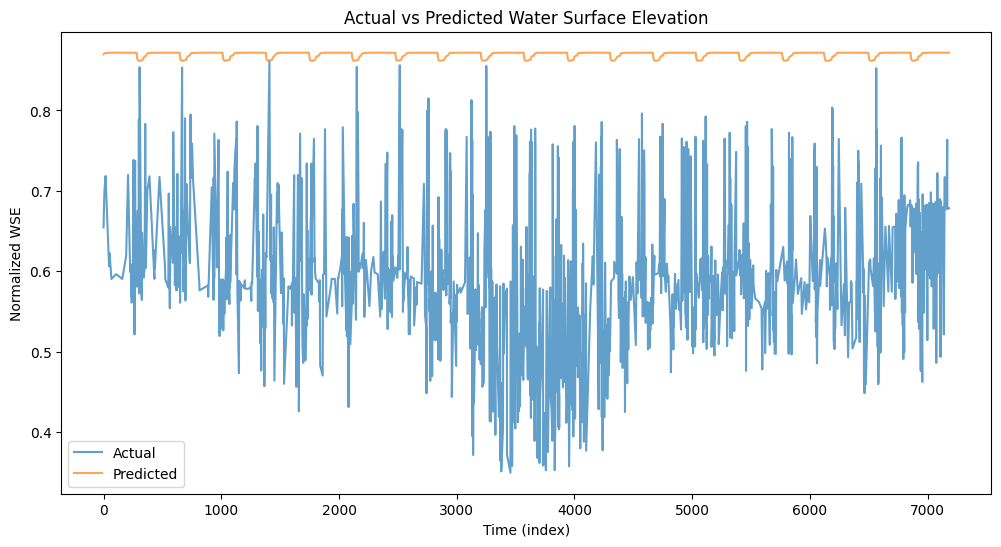

In [ ]:
import matplotlib.pyplot as plt
# Plot actual vs predicted

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual", alpha=0.7)
plt.plot(test_outputs, label="Predicted", alpha=0.7)
plt.xlabel("Time (index)")
plt.ylabel("Normalized WSE")
plt.title("Actual vs Predicted Water Surface Elevation")
plt.legend()
plt.show()

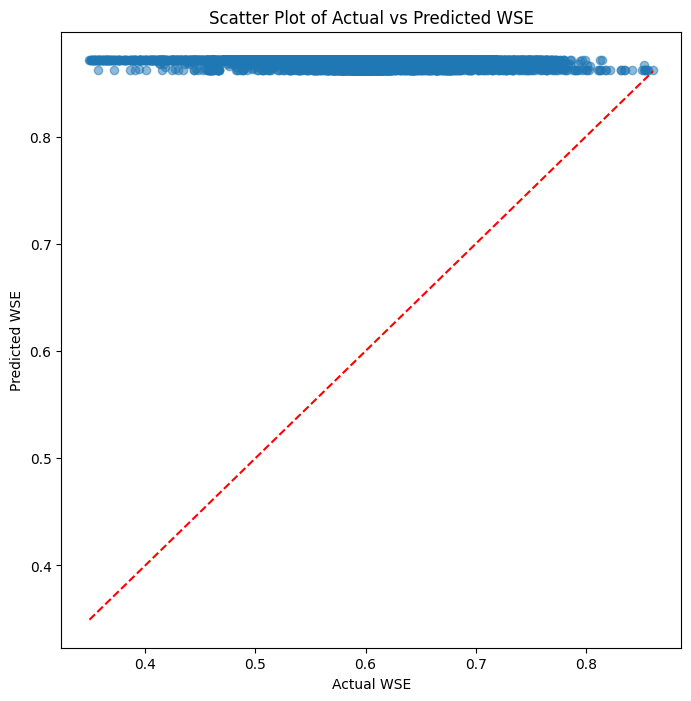

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, test_outputs, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line
plt.xlabel("Actual WSE")
plt.ylabel("Predicted WSE")
plt.title("Scatter Plot of Actual vs Predicted WSE")
plt.show()


In [ ]:
test_outputs.min()

0.86170274

In [ ]:
test_outputs.max()

0.8717389

Okay, so it seems like the model is severly underfitting the data, as it's effectively just constant! This probably means we need to go back to the drawing board with the hyperparameters.

In the meantime, I think it might be a good idea to constrain the wells used to train this model to those whose max WSEs are relatively similar to each other so as to ensure less erratic data. With this in mind, let's see how the water level ranges vary between wells:

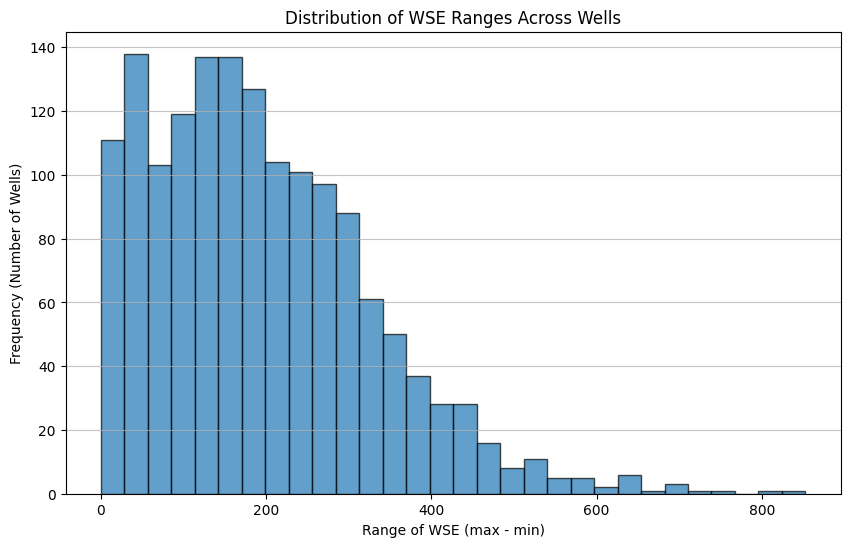

In [ ]:
well_ranges = df.groupby('WELL_NAME')['WSE'].agg(lambda x: x.max() - x.min())

plt.figure(figsize=(10, 6))
plt.hist(well_ranges, bins=30, edgecolor='black', alpha=0.7)  # Adjust bins as needed
plt.xlabel('Range of WSE (max - min)')
plt.ylabel('Frequency (Number of Wells)')
plt.title('Distribution of WSE Ranges Across Wells')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
model2 = LSTMModel(input_dim=X_train_seq.shape[2], hidden_dim=128, num_layers=3, output_dim=1, dropout=0.3)

sequence_length = 90


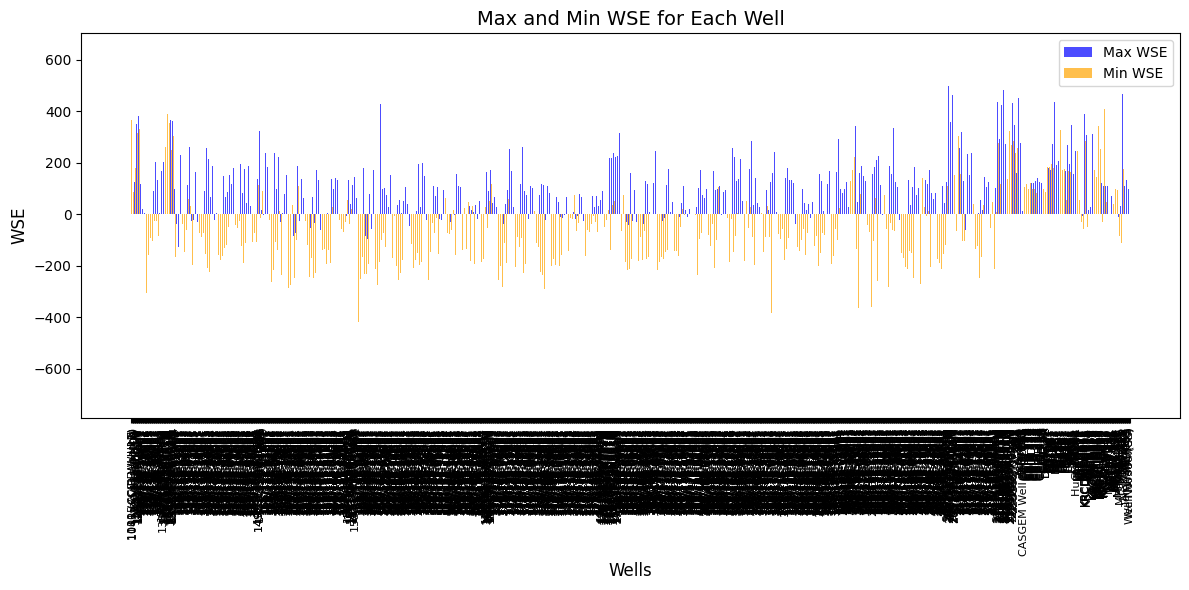

In [ ]:
# Group by 'WELL_NAME' and calculate max and min WSE for each well
well_stats = df.groupby('WELL_NAME')['WSE'].agg(['max', 'min']).reset_index()

# Extract max and min values
wells = well_stats['WELL_NAME']
max_wse = well_stats['max']
min_wse = well_stats['min']

# Set up the plot
x = np.arange(len(wells))  # Positions for the wells
bar_width = 0.35  # Width of each bar

plt.figure(figsize=(12, 6))

# Plot max and min as side-by-side bars
plt.bar(x - bar_width / 2, max_wse, bar_width, label='Max WSE', color='blue', alpha=0.7)
plt.bar(x + bar_width / 2, min_wse, bar_width, label='Min WSE', color='orange', alpha=0.7)

# Add labels and title
plt.xlabel('Wells', fontsize=12)
plt.ylabel('WSE', fontsize=12)
plt.title('Max and Min WSE for Each Well', fontsize=14)
plt.xticks(x, wells, rotation=90, fontsize=8)  # Rotate well names for better visibility
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
num_unique_wells = df['WELL_NAME'].nunique()
print(f"Number of unique wells: {num_unique_wells}")

Number of unique wells: 1527


Upon further investigation, we see that there are a concerning number of negative WSE values. No wonder our model can't predict anything! We're going to need to standardize WSE by working with some of the metadata, namely the GSE and RPE columns (ground surface elevation and reference point elevation) and making a few educated guesses.

In [ ]:
wells_with_only_positive_wse = (
    df.groupby('STN_ID')
    .filter(lambda group: (group['WSE'] >= 0).all())['STN_ID']
    .unique()
)

print("Wells with exclusively positive WSE values:")
print(wells_with_only_positive_wse)
print(f"Number of wells with exclusively positive WSE values: {len(wells_with_only_positive_wse)}")


total_wells = df['STN_ID'].nunique()
print(f"Total number of wells in the dataset: {total_wells}")

One approach here is to work with only the wells that have positive WSE values, with the loose assumption that these all have the same standardized measurement of WSE. Let's try working with this subset of the dataset.

In [ ]:
exclusively_nonnegative_wse_df = df[df['STN_ID'].isin(wells_with_only_positive_wse)]

In [ ]:
exclusively_nonnegative_wse_df

Fortunately, we still have over 16000 records to work with. But this time, before we jump straight into analyzing them, let's plot the values to see what they look like. Again, treating all WSE measurements as if they come from the same well, we have the following:

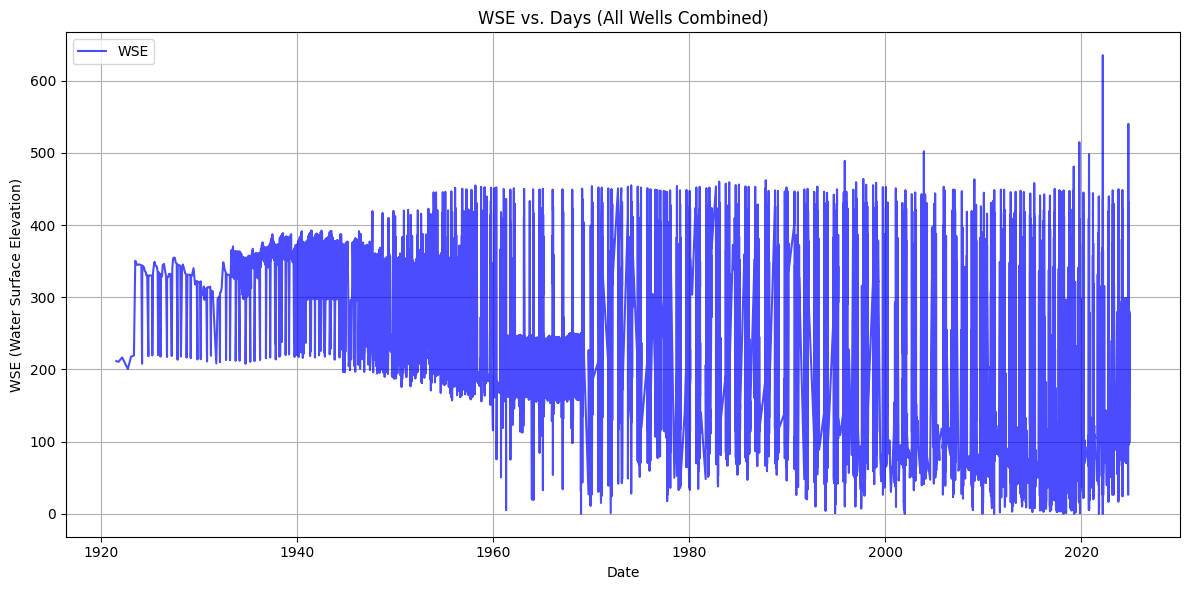

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
exclusively_nonnegative_wse_df = exclusively_nonnegative_wse_df.sort_values('MSMT_DATE')

plt.plot(exclusively_nonnegative_wse_df['MSMT_DATE'], exclusively_nonnegative_wse_df['WSE'], label="WSE", color='blue', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('WSE (Water Surface Elevation)')
plt.title('WSE vs. Days (All Wells Combined)')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()


Okay, much better. The WSE is still quite volatile, but this is to be expected, even from a single well. Let's also visualize this as a scatter plot:

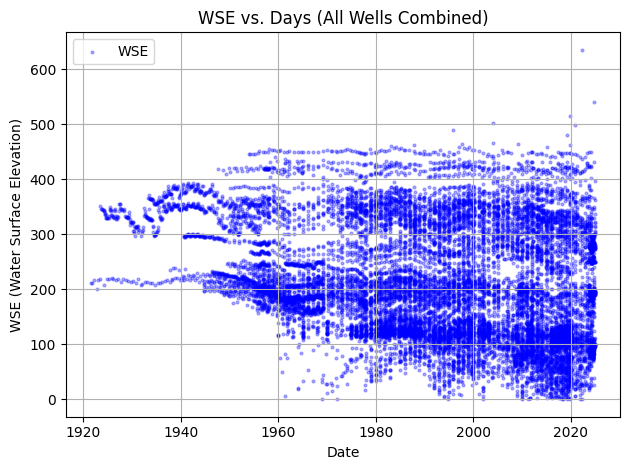

In [ ]:
plt.scatter(exclusively_nonnegative_wse_df['MSMT_DATE'], exclusively_nonnegative_wse_df['WSE'], label="WSE", color='blue', alpha=0.3, s=4)

plt.xlabel('Date')
plt.ylabel('WSE (Water Surface Elevation)')
plt.title('WSE vs. Days (All Wells Combined)')
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()


In [ ]:
# Group by well ID and filter wells where the maximum WSE is ≤ 310
wells_never_exceeding_310 = exclusively_nonnegative_wse_df.groupby('STN_ID').filter(
    lambda group: group['WSE'].max() <= 310
)['STN_ID'].unique()

# Display the well IDs
print("Wells where WSE never exceeds 310 feet:")
print(wells_never_exceeding_310)

# Count the number of such wells
print(f"Number of wells where WSE never exceeds 310 feet: {len(wells_never_exceeding_310)}")

Wells where WSE never exceeds 310 feet:
[14451 15824 32863 18124 14964 33401 33688 56122 56124 33693 15839 32261
 15286 20972 15298 15673 15290 32571 56119 35379 14595 20449 18110 18093
 14411 32670 39036 33644 13892 15115 15679 39896 14449 13430 14754 51162
 13428 15300 35844 13444 14903 14901 35372 18112 19458 14890 35845 33514
 32958 13945 13402 33673 32654 13934 33672 14203 13426 14906 13947 14774
 20989 20987 14917 14905 33255 13935 14106 14245 14775 31827 13943 34739
 20744 35319 18099 36433 17666 18091 15077 15078 15599 15463 13949 34360
 39362 20740 36262 15795 14932 15747 13529 15045 21120 21118 21121 34654
 48588 15738 15058 13534 21136 35375 20823 13725 13401 13404 39389 21884
 20996 34361 22912 32542 20993 13527 34770 22900 34558 32163 15730 32536
 20821 20298 34640 22898 21882 14236 15042 35888 17901 54081 53698 17526
 34977 18742 21099 20948 34349 34235 31891 34610 17346 19124 21111 21358
 39981 31870 35778 32625 19457 14371 31826 31872 16430 15741 19288 35776
 35542 1929

<ipython-input-33-e1a230e0c0d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wells_data_never_exceeding_310['MSMT_DATE'] = pd.to_datetime(


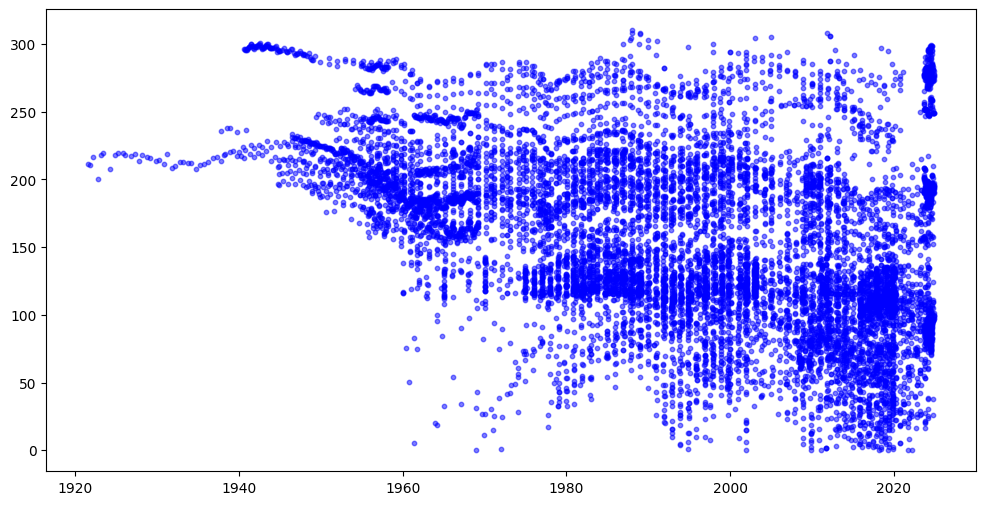

In [ ]:
wells_data_never_exceeding_310 = exclusively_nonnegative_wse_df[
  exclusively_nonnegative_wse_df['STN_ID'].isin(wells_never_exceeding_310)
]

# Ensure MSMT_DATE is in datetime format and sort the data by date
wells_data_never_exceeding_310['MSMT_DATE'] = pd.to_datetime(
  wells_data_never_exceeding_310['MSMT_DATE'], errors='coerce'
)
wells_data_never_exceeding_310 = wells_data_never_exceeding_310.sort_values('MSMT_DATE')

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(
  wells_data_never_exceeding_310['MSMT_DATE'],
  wells_data_never_exceeding_310['WSE'],
  label="WSE (Never > 310 ft)",
  color='blue',
  alpha=0.5,
  s=10
)

# Add labels, title, and grid


plt.show()

In [ ]:
wells_data_never_exceeding_310

,MSMT_DATE,SITE_CODE,WELL_NAME,SWN,STN_ID,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,...,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,WSE_normalized,year,month,day,dayofyear
0,1921-08-03 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,211.50,19.2,18.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.687969,1921,8,3,215
1,1921-10-26 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,210.50,20.2,19.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.687232,1921,10,26,299
2,1922-03-09 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,216.70,14.0,13.2,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.691798,1922,3,9,68
3,1922-10-07 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,200.50,30.2,29.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.679867,1922,10,7,280
4,1923-02-02 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,217.60,13.1,12.3,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.692461,1923,2,2,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37171,2024-11-22 10:50:00,365330N1196470W001,DeWolf 2,16S21E14R002M,60824,194.14,95.5,95.5,289.64,289.64,...,NaN,NaN,DeWolf 2,11/22/2024 15:25,guevara,0.675183,2024,11,22,327
37172,2024-11-22 11:05:00,365333N1196491W001,DeWolf 1,16S21E14R001M,60825,195.19,99.4,98.8,294.59,293.99,...,8,Oil or foreign substance in casing,DeWolf 1,11/22/2024 15:25,guevara,0.675956,2024,11,22,327
37173,2024-11-22 11:33:00,365509N1196648W001,Temperance 1,16S21E10J001M,60969,195.86,93.9,93.9,289.76,289.76,...,NaN,NaN,Temperance 1,11/22/2024 15:25,guevara,0.676450,2024,11,22,327
37174,2024-11-22 12:14:00,365652N1198001W001,Nebraska #2,16S20E04P001M,60743,99.59,161.7,161.0,261.29,260.59,...,8,Oil or foreign substance in casing,Nebraska 2,11/22/2024 15:25,guevara,0.605547,2024,11,22,327


In [ ]:
exclusively_nonnegative_wse_df.set_index('MSMT_DATE', inplace=True)
numeric_columns = exclusively_nonnegative_wse_df.select_dtypes(include=['float64', 'int64']).columns

resampled_nonnegative_wse_df = exclusively_nonnegative_wse_df[numeric_columns].resample('D').mean().interpolate()

resampled_nonnegative_wse_df = resampled_nonnegative_wse_df.reset_index()

exclusively_nonnegative_wse_df = exclusively_nonnegative_wse_df.reset_index()

resampled_nonnegative_wse_df.head()

,MSMT_DATE,STN_ID,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,RDNG_RP,RDNG_WS,WLM_ORG_ID,WSE_normalized
0,1921-08-03,14451.0,211.500000,19.200000,18.400000,230.7,229.9,19.200000,0.0,1.0,0.687969
1,1921-08-04,14451.0,211.488095,19.211905,18.411905,230.7,229.9,19.211905,0.0,1.0,0.687960
2,1921-08-05,14451.0,211.476190,19.223810,18.423810,230.7,229.9,19.223810,0.0,1.0,0.687951
3,1921-08-06,14451.0,211.464286,19.235714,18.435714,230.7,229.9,19.235714,0.0,1.0,0.687942
4,1921-08-07,14451.0,211.452381,19.247619,18.447619,230.7,229.9,19.247619,0.0,1.0,0.687934


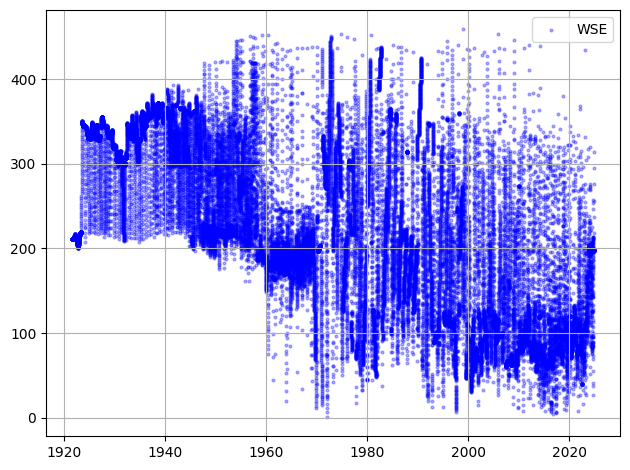

In [ ]:
plt.scatter(resampled_nonnegative_wse_df['MSMT_DATE'], resampled_nonnegative_wse_df['WSE'], label="WSE", color='blue', alpha=0.3, s=4)

plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

The interpolated dataset looks a little different from the original one, but the same volatility and downward trend are there. Arguably, this could suffice for artistic purposes.

In [ ]:
resampled_nonnegative_wse_df.columns

Index(['MSMT_DATE', 'STN_ID', 'WSE', 'RPE_WSE', 'GSE_WSE', 'WLM_RPE',
       'WLM_GSE', 'RDNG_RP', 'RDNG_WS', 'WLM_ORG_ID', 'WSE_normalized'],
      dtype='object')

In [ ]:
resampled_nonnegative_wse_df['year'] = resampled_nonnegative_wse_df['MSMT_DATE'].dt.year
resampled_nonnegative_wse_df['month'] = resampled_nonnegative_wse_df['MSMT_DATE'].dt.month
resampled_nonnegative_wse_df['day'] = resampled_nonnegative_wse_df['MSMT_DATE'].dt.day
resampled_nonnegative_wse_df['dayofyear'] = resampled_nonnegative_wse_df['MSMT_DATE'].dt.dayofyear


features = ['year', 'month', 'day', 'dayofyear']
target = 'WSE_normalized'

X = resampled_nonnegative_wse_df[features]
y = resampled_nonnegative_wse_df[target]

# Sequential train-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, shuffle=False
)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

NameError: name 'resampled_nonnegative_wse_df' is not defined

In [ ]:
sequence_length = 128 # going for a shorter sequence length this time

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

print(f"Training sequences: {X_train_seq.shape}, Validation sequences: {X_val_seq.shape}, Test sequences: {X_test_seq.shape}")

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
X_train_tensor = torch.FloatTensor(X_train_seq)
y_train_tensor = torch.FloatTensor(y_train_seq)
X_val_tensor = torch.FloatTensor(X_val_seq)
y_val_tensor = torch.FloatTensor(y_val_seq)
X_test_tensor = torch.FloatTensor(X_test_seq)
y_test_tensor = torch.FloatTensor(y_test_seq)


Let's take a moment to save this interpolated subset of our dataset for future use:

In [ ]:
path = '/content/drive/MyDrive/FresnoCountyWells/'
resampled_nonnegative_wse_df.to_csv(path + 'resampled_nonnegative_wse.csv', index=False)

Now to instantiate the model architecture, give values to our hyperparameters, and try again with the training loop. We're going to make a function for the loop instead of just having the cell be the loop. Let's hope it works this time!

In [ ]:
# Hyperparams
input_dim = X_train_seq.shape[2]  # Number of input features (ex: year, month, day, etc.)
hidden_dim = 64
num_layers = 2
output_dim = 1
dropout = 0.2
learning_rate = 0.001

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout)
print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
# Training loop
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=100, batch_size=32):
  train_losses = []
  val_losses = []

  for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
      batch_X = X_train_tensor[i:i+batch_size]
      batch_y = y_train_tensor[i:i+batch_size]

      # Forward
      optimizer.zero_grad()
      outputs = model(batch_X)
      loss = criterion(outputs.squeeze(), batch_y)

      # Backward
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

      train_losses.append(epoch_loss / len(X_train_tensor))

      # Validation
      model.eval()  # Evaluate
      with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor).item()
        val_losses.append(val_loss)

      # Epoch progress
      if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [ ]:
epochs = 100
batch_size = 32

train_losses, val_losses = train_model(
    model,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs=epochs,
    batch_size=batch_size,
)

Epoch [1/100], Train Loss: 0.0003, Val Loss: 0.0047
Epoch [5/100], Train Loss: 0.0001, Val Loss: 0.0046
Epoch [10/100], Train Loss: 0.0001, Val Loss: 0.0046
Epoch [15/100], Train Loss: 0.0001, Val Loss: 0.0046
Epoch [20/100], Train Loss: 0.0001, Val Loss: 0.0047
Epoch [25/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [30/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [35/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [40/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [45/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [50/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [55/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [60/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [65/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [70/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [75/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [80/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [85/100], Train Loss: 0.0001, Val Loss: 0.0048
Epoch [90/100], Train Loss: 0.0001, Val Loss: 0.

From the looks of it, the model doesn't seem to have learned quite optimally; validation loss is only not decreasing and instead is just going up. This is a sign of overfitting, and we have a few options to combat it.

First, we could try increasing dropout (which is currently 0.2) to around 0.3 to help decrease overreliance on certain nodes.

Second, we could perhaps decrease the learning rate a bit. This tends to be good for avoiding oscilations in the validation error, some of which we're experiencing.

One more thing we could try is removing wells with extreme or anomalous WSE values. I was more or less under the impression that we'd already done that by limiting to only positive WSE values, looking at the interpolated graph, there are a few very high WSE values.

First though, let's see how the model performs!

In [ ]:
model.eval() # Evaluation mode

with torch.no_grad():
  test_predictions = model(X_test_tensor).squeeze()

test_predictions = test_predictions.cpu().numpy()
y_test_actual = y_test_tensor.cpu().numpy()

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test_actual, test_predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

Mean Squared Error (MSE): 0.0054
Root Mean Squared Error (RMSE): 0.0734


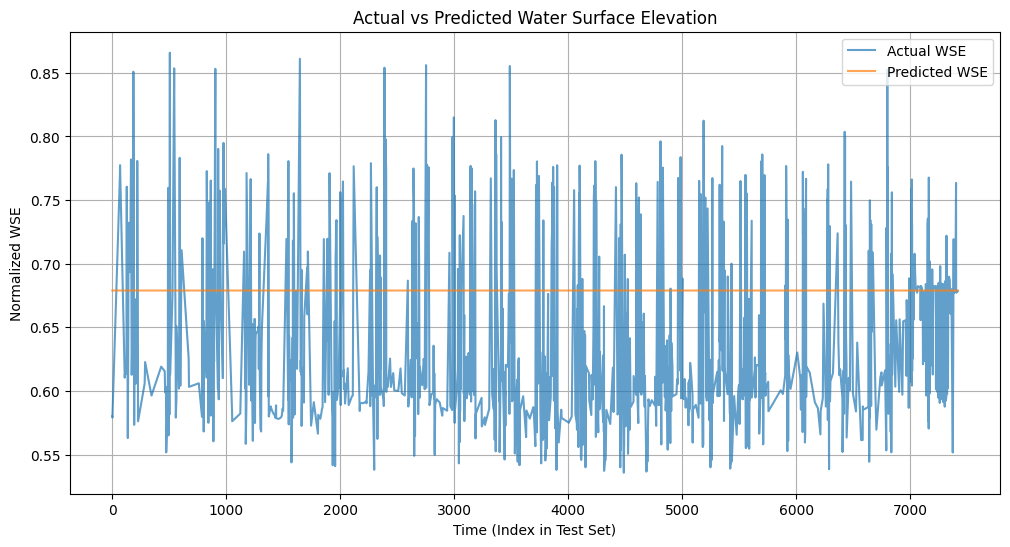

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Actual WSE", alpha=0.7)
plt.plot(test_predictions, label="Predicted WSE", alpha=0.7)
plt.xlabel("Time (Index in Test Set)")
plt.ylabel("Normalized WSE")
plt.title("Actual vs Predicted Water Surface Elevation")
plt.legend()
plt.grid()
plt.show()


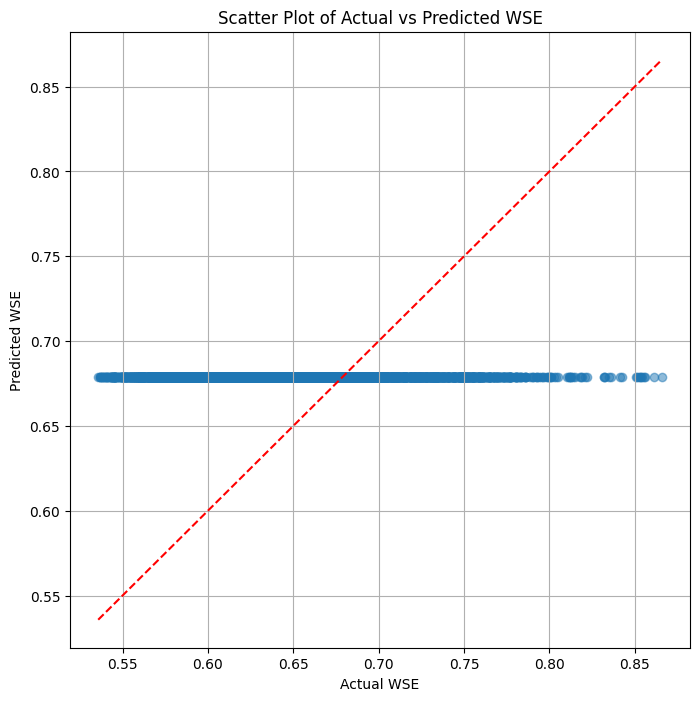

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test_actual, test_predictions, alpha=0.5)
plt.plot([min(y_test_actual), max(y_test_actual)], [min(y_test_actual), max(y_test_actual)], 'r--')  # Diagonal line
plt.xlabel("Actual WSE")
plt.ylabel("Predicted WSE")
plt.title("Scatter Plot of Actual vs Predicted WSE")
plt.grid()
plt.show()


**NOTE**

At this point, I'm almost completely out of ideas for how to make the LSTM work, and I'm going to start relying extremely heavily on AI.

In [ ]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation for inference
with torch.no_grad():
  # Make predictions on the training set
  train_predictions = model(X_train_tensor).squeeze()  # Squeeze for dimension correction

# Convert predictions and actual values to NumPy for visualization
train_predictions = train_predictions.cpu().numpy()
y_train_actual = y_train_tensor.cpu().numpy()

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate MSE and RMSE for the training set
train_mse = mean_squared_error(y_train_actual, train_predictions)
train_rmse = np.sqrt(train_mse)

print(f"Training Set Mean Squared Error (MSE): {train_mse:.4f}")
print(f"Training Set Root Mean Squared Error (RMSE): {train_rmse:.4f}")

Training Set Mean Squared Error (MSE): 0.4468
Training Set Root Mean Squared Error (RMSE): 0.6684


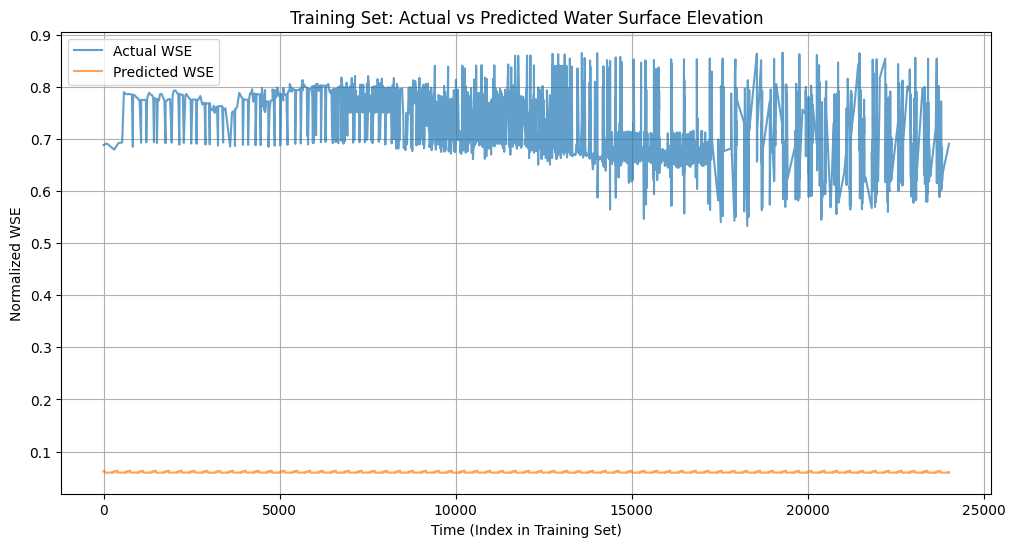

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train_actual, label="Actual WSE", alpha=0.7)
plt.plot(train_predictions, label="Predicted WSE", alpha=0.7)
plt.xlabel("Time (Index in Training Set)")
plt.ylabel("Normalized WSE")
plt.title("Training Set: Actual vs Predicted Water Surface Elevation")
plt.legend()
plt.grid()
plt.show()

In [ ]:
class LSTMModel2(nn.Module):
  def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
    super(LSTMModel2, self).__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers

    # LSTM layers
    self.lstm = nn.LSTM(
      input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout
    )

    # Fully connected layers
    self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)  # First dense layer
    self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)  # Second dense layer
    self.fc3 = nn.Linear(hidden_dim // 4, output_dim)  # Output layer

    self.relu = nn.ReLU()

  def forward(self, x):

    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

    out, _ = self.lstm(x, (h0, c0))

    out = out[:, -1, :]

    out = self.fc1(out)
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)

    return out

In [ ]:
X_train_tensor = X_train_tensor[:100]
y_train_tensor = y_train_tensor[:100]

In [ ]:
# Define the model
input_dim = X_train_tensor.shape[2]  # Number of input features
output_dim = 1  # Single output
num_layers = 5  # Increase the number of LSTM layers
hidden_dim = 256  # Larger hidden dimension
dropout = 0.0  # Disable dropout to encourage overfitting

# Instantiate the LSTM model
model = LSTMModel2(input_dim, hidden_dim, num_layers, output_dim, dropout)
print(model)

# Define the optimizer with no regularization (weight decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0)

# Define the loss function
criterion = nn.MSELoss()

# Define the number of epochs
epochs = 200

LSTMModel2(
  (lstm): LSTM(4, 256, num_layers=5, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
def train_model_with_early_stopping(
    model,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    optimizer,
    criterion,
    epochs=500,
    batch_size=32,
    patience=10,  # Number of epochs to wait for improvement
    delta=0.001,  # Minimum improvement to be considered significant
    save_path="best_model.pth"  # Path to save the best model
):
    best_val_loss = float('inf')  # Initialize the best validation loss
    patience_counter = 0  # Track epochs without improvement
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for i in range(0, len(X_train_tensor), batch_size):
            # Get batch data
            batch_X = X_train_tensor[i:i + batch_size]
            batch_y = y_train_tensor[i:i + batch_size]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Compute average training loss for the epoch
        train_loss /= len(X_train_tensor)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs.squeeze(), y_val_tensor).item()
            val_losses.append(val_loss)

        # Early stopping logic
        if val_loss < best_val_loss - delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)  # Save the best model
            print(f"Epoch {epoch + 1}: Validation loss improved to {val_loss:.4f}. Saving model.")
        else:
            patience_counter += 1
            print(f"Epoch {epoch + 1}: Validation loss did not improve (patience {patience_counter}/{patience}).")

        # Stop training if patience is exceeded
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

        # Print epoch summary
        print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Load the best model before returning
    model.load_state_dict(torch.load(save_path))
    return train_losses, val_losses

In [ ]:
import time

start_time = time.time()

train_losses, val_losses = train_model_with_early_stopping(
    model=model,
    X_train_tensor=X_train_tensor,
    y_train_tensor=y_train_tensor,
    X_val_tensor=X_val_tensor,
    y_val_tensor=y_val_tensor,
    optimizer=optimizer,
    criterion=criterion,
    epochs=200,
    batch_size=32,
    patience=10,
    delta=0.001,
    save_path="best_model.pth"
)

end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1: Validation loss improved to 0.4161. Saving model.
Epoch [1/200] - Train Loss: 0.0227, Val Loss: 0.4161
Epoch 2: Validation loss improved to 0.0424. Saving model.
Epoch [2/200] - Train Loss: 0.0118, Val Loss: 0.0424
Epoch 3: Validation loss did not improve (patience 1/10).
Epoch [3/200] - Train Loss: 0.0013, Val Loss: 0.0747
Epoch 4: Validation loss improved to 0.0051. Saving model.
Epoch [4/200] - Train Loss: 0.0010, Val Loss: 0.0051
Epoch 5: Validation loss did not improve (patience 1/10).
Epoch [5/200] - Train Loss: 0.0005, Val Loss: 0.0132
Epoch 6: Validation loss did not improve (patience 2/10).
Epoch [6/200] - Train Loss: 0.0003, Val Loss: 0.0055
Epoch 7: Validation loss did not improve (patience 3/10).
Epoch [7/200] - Train Loss: 0.0001, Val Loss: 0.0160
Epoch 8: Validation loss did not improve (patience 4/10).
Epoch [8/200] - Train Loss: 0.0001, Val Loss: 0.0060
Epoch 9: Validation loss did not improve (patience 5/10).
Epoch [9/200] - Train Loss: 0.0000, Val Loss: 0.004

<ipython-input-42-d1a13d3248f8>:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


In [ ]:
model.eval()

LSTMModel2(
  (lstm): LSTM(4, 256, num_layers=5, batch_first=True)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

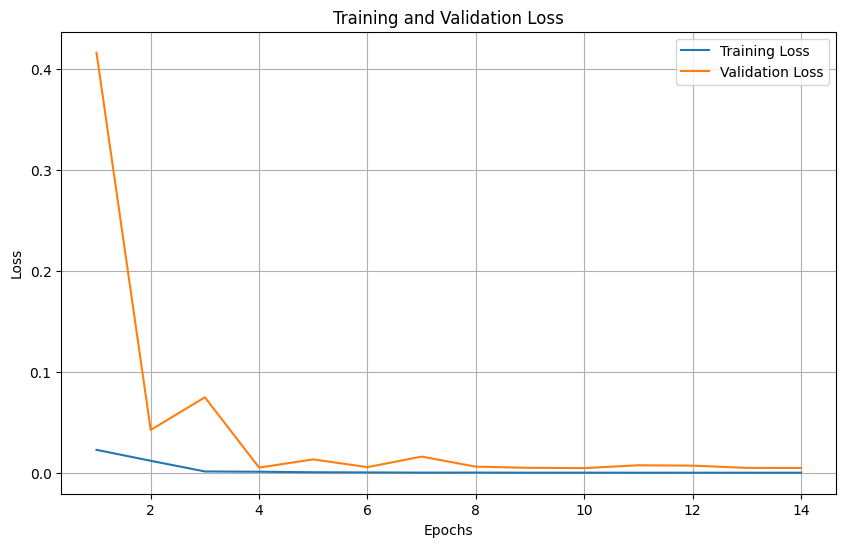

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# Generate predictions on the test set
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).squeeze()
    test_outputs = test_outputs.cpu().numpy()
    y_test = y_test_tensor.cpu().numpy()

# Calculate metrics
mse = mean_squared_error(y_test, test_outputs)
rmse = np.sqrt(mse)

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MSE: 0.0028
Test RMSE: 0.0531


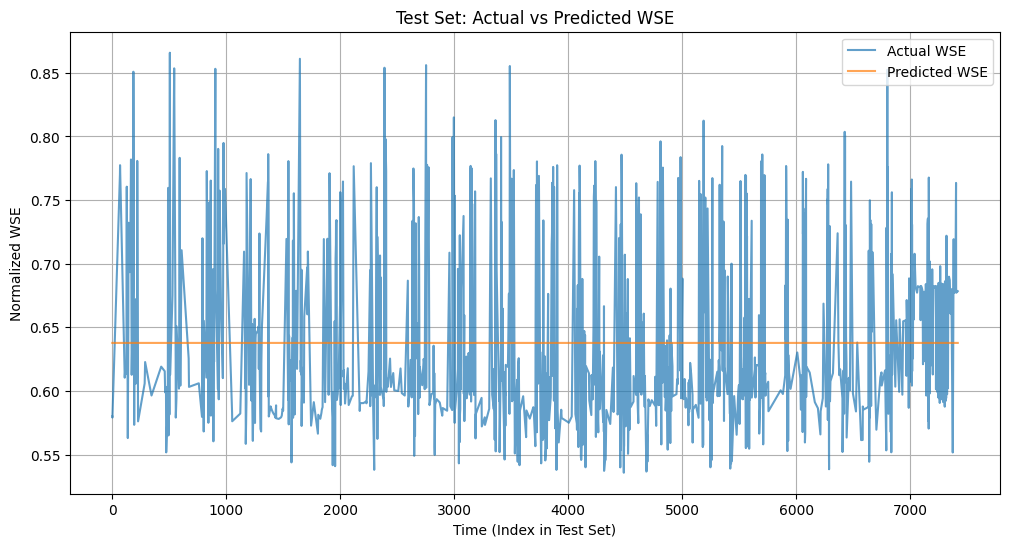

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual WSE", alpha=0.7)
plt.plot(test_outputs, label="Predicted WSE", alpha=0.7)
plt.xlabel("Time (Index in Test Set)")
plt.ylabel("Normalized WSE")
plt.title("Test Set: Actual vs Predicted WSE")
plt.legend()
plt.grid()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Ensure the model is in evaluation mode
model.eval()

# Generate predictions on the training set
with torch.no_grad():
    train_outputs = model(X_train_tensor).squeeze()  # Predictions
    train_outputs = train_outputs.cpu().numpy()      # Convert to NumPy
    y_train_actual = y_train_tensor.cpu().numpy()    # Convert actual values to NumPy

In [ ]:
# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
train_mse = mean_squared_error(y_train_actual, train_outputs)
train_rmse = np.sqrt(train_mse)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")

Training MSE: 0.0028
Training RMSE: 0.0526


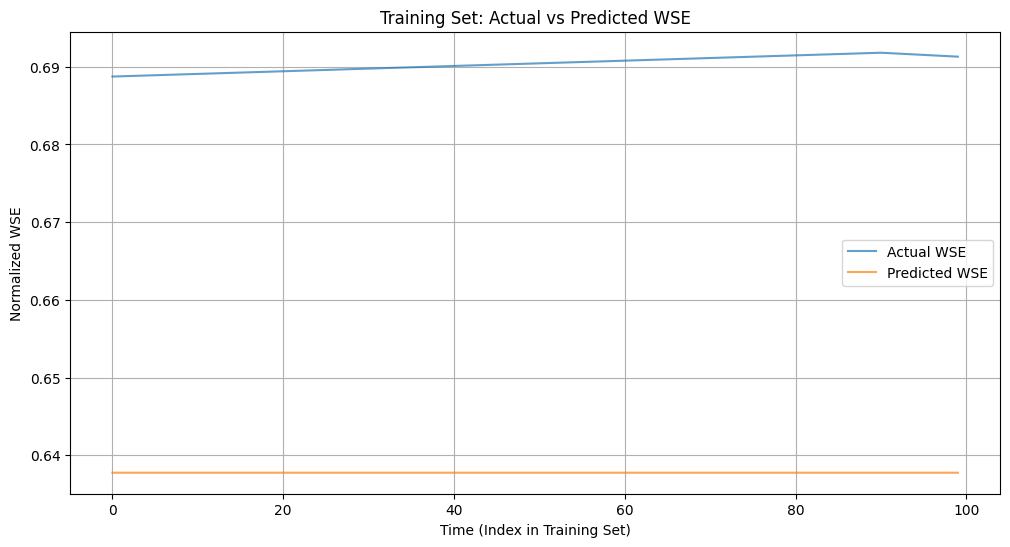

In [ ]:
# Line plot: Actual vs Predicted on Training Set
plt.figure(figsize=(12, 6))
plt.plot(y_train_actual, label="Actual WSE", alpha=0.7)
plt.plot(train_outputs, label="Predicted WSE", alpha=0.7)
plt.xlabel("Time (Index in Training Set)")
plt.ylabel("Normalized WSE")
plt.title("Training Set: Actual vs Predicted WSE")
plt.legend()
plt.grid()
plt.show()

This was a test to see whether the LSTM architecture could overfit a very small subset of the data given a rigorous training loop. This doesn't seem to have been possible, even when running on GPUs. So, unfortunately, it looks like the attempt to predict water levels as a sequence by building an LSTM has failed.

It seems like my only option now is to switch to a multiple linear regression model.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df

,MSMT_DATE,SITE_CODE,WELL_NAME,SWN,STN_ID,WSE,RPE_WSE,GSE_WSE,WLM_RPE,WLM_GSE,...,WLM_QA_CODE,WLM_QA_DESC,MSMT_CMT,WLM_MOD_DATE,WLM_MOD_USER,WSE_normalized,year,month,day,dayofyear
0,1921-08-03 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,211.50,19.2,18.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.687969,1921,8,3,215
1,1921-10-26 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,210.50,20.2,19.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.687232,1921,10,26,299
2,1922-03-09 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,216.70,14.0,13.2,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.691798,1922,3,9,68
3,1922-10-07 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,200.50,30.2,29.4,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.679867,1922,10,7,280
4,1923-02-02 00:00:00,367249N1200246W001,FD8J1,14S18E08J001M,14451,217.60,13.1,12.3,230.70,229.90,...,NaN,NaN,NaN,08/18/2021 08:09,esenter,0.692461,1923,2,2,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37171,2024-11-22 10:50:00,365330N1196470W001,DeWolf 2,16S21E14R002M,60824,194.14,95.5,95.5,289.64,289.64,...,NaN,NaN,DeWolf 2,11/22/2024 15:25,guevara,0.675183,2024,11,22,327
37172,2024-11-22 11:05:00,365333N1196491W001,DeWolf 1,16S21E14R001M,60825,195.19,99.4,98.8,294.59,293.99,...,8,Oil or foreign substance in casing,DeWolf 1,11/22/2024 15:25,guevara,0.675956,2024,11,22,327
37173,2024-11-22 11:33:00,365509N1196648W001,Temperance 1,16S21E10J001M,60969,195.86,93.9,93.9,289.76,289.76,...,NaN,NaN,Temperance 1,11/22/2024 15:25,guevara,0.676450,2024,11,22,327
37174,2024-11-22 12:14:00,365652N1198001W001,Nebraska #2,16S20E04P001M,60743,99.59,161.7,161.0,261.29,260.59,...,8,Oil or foreign substance in casing,Nebraska 2,11/22/2024 15:25,guevara,0.605547,2024,11,22,327


This 'SITE_CODE' column is obviously made up of something akin to latitudes and longitudes, and while we couldn't use them for the LSTM due to its sequential nature, these might be useful features for MLE. Hence, below, we extract them and give them their own columns in our dataframe.

In [ ]:
MLE_df = wells_data_never_exceeding_310

MLE_df = MLE_df.dropna(subset=['SITE_CODE'])
MLE_df['SITE_CODE'] = MLE_df['SITE_CODE'].astype(str)

MLE_df['N'] = MLE_df['SITE_CODE'].str.extract(r'(\d+)(?=N)', expand=False)
MLE_df['W'] = MLE_df['SITE_CODE'].str.extract(r'(\d+)(?=W)', expand=False)

MLE_df['N'] = MLE_df['N'].astype(float)
MLE_df['W'] = MLE_df['W'].astype(float)

In [ ]:
feature_columns = ['N', 'W', 'year', 'month', 'day', 'dayofyear']
X = MLE_df[feature_columns]

y = MLE_df['WSE']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (11376, 6)
y shape: (11376,)


In [ ]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 7280
Validation set size: 1820
Test set size: 2276


In [ ]:
# Checks how many nan values are in the features matrix and target

print(X.isna().sum())
print(y.isna().sum())

N            0
W            0
year         0
month        0
day          0
dayofyear    0
dtype: int64
0


In [ ]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

print("Model Coefficients:", linear_model.coef_)
print("Model Intercept:", linear_model.intercept_)

Model Coefficients: [ 4.65719953e-03 -1.22368782e-02 -9.14252266e-01  8.52010254e+00
 -1.05971315e-02 -2.77064994e-01]
Model Intercept: 14956.375572734947


In [ ]:
y_train_pred = linear_model.predict(X_train)

train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Training MSE: {train_mse:.4f}")
print(f"Training R_squared: {train_r2:.4f}")


Training MSE: 2533.6956
Training R_squared: 0.4018


In [ ]:
y_val_pred = linear_model.predict(X_val)

val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"Validation MSE: {val_mse:.4f}")
print(f"Validation R_squared: {val_r2:.4f}")

Validation MSE: 2601.4959
Validation R_squared: 0.3821


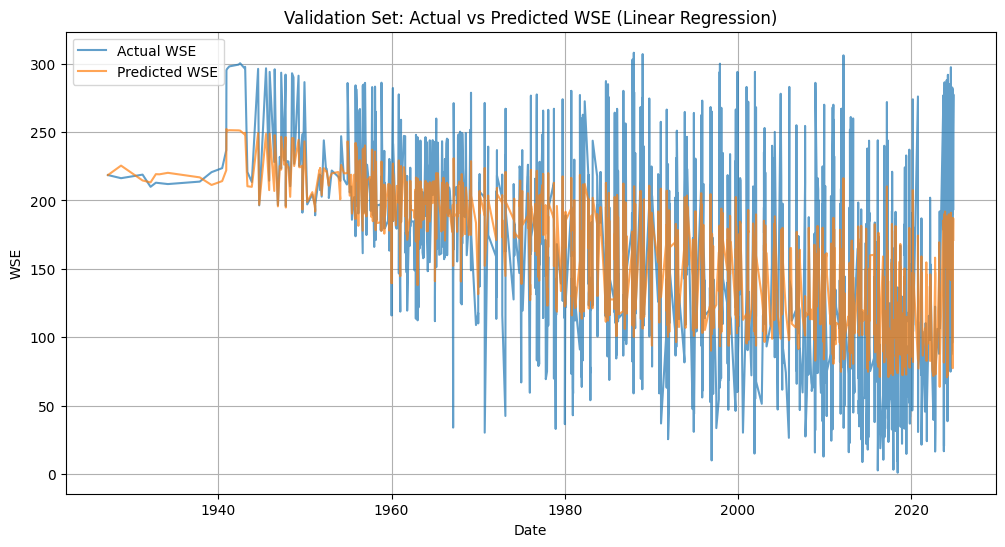

In [ ]:
# Retrieve the corresponding dates for validation set
val_dates = MLE_df.loc[X_val.index, 'MSMT_DATE']

# Combine predictions and dates
val_results = pd.DataFrame({
    'Date': val_dates,
    'Actual_WSE': y_val.values,
    'Predicted_WSE': y_val_pred
}).sort_values('Date')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(val_results['Date'], val_results['Actual_WSE'], label="Actual WSE", alpha=0.7)
plt.plot(val_results['Date'], val_results['Predicted_WSE'], label="Predicted WSE", alpha=0.7)
plt.xlabel("Date")
plt.ylabel("WSE")
plt.title("Validation Set: Actual vs Predicted WSE (Linear Regression)")
plt.legend()
plt.grid()
plt.show()

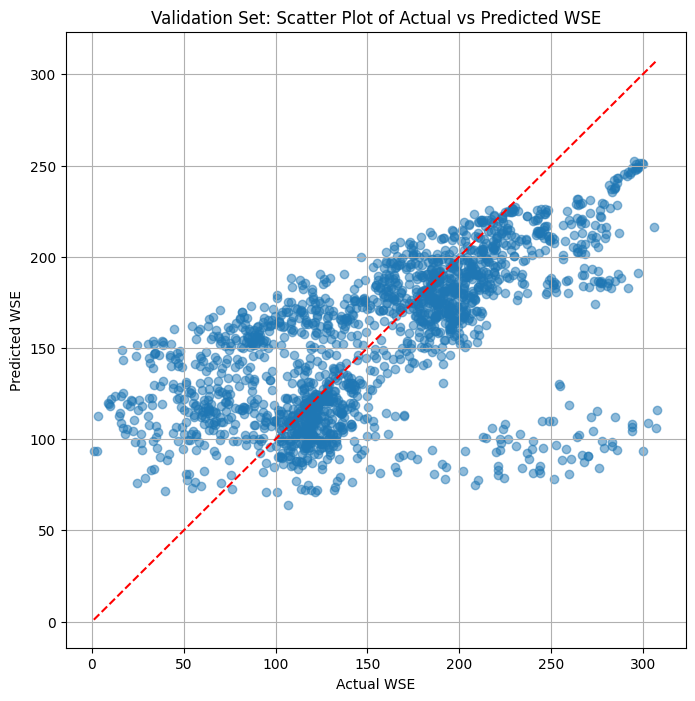

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')  # Diagonal line
plt.xlabel("Actual WSE")
plt.ylabel("Predicted WSE")
plt.title("Validation Set: Scatter Plot of Actual vs Predicted WSE")
plt.grid()
plt.show()

It's a little ironic how little time went into this far superior linear model compared to the hours that went into several failed LSTM attempts😭

Now how does this model do on the test set?

In [ ]:
y_test_pred = linear_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.4f}")
print(f"Test R_squared: {test_r2:.4f}")

Test MSE: 2381.9909
Test R_squared: 0.4376


Now, there are a few ways in which we could use this model to predict when the water will run out. In all of them, we need to simulate records of well measurements being taken in the future. If we keep everything but the 'year' column constant, the model will probably only output a straight line; therefore, here's what we'll do for each of our features:


*   N and W: shuffle actual N/W pairs from the dataset
*   month: loop from 1 through 12 over and over
*   year: stay constant for 12 records (so that each month has a turn per year), then increment
*   dayofyear: increment by 30 for each record (roughly one month)
*   day: the only fixed parameter (fixed at 1, so the first of each month)

Effectively, the temporal resolution of this future X is one month. Let's see how our predictions do 200 years out.


In [ ]:
future_years = range(MLE_df['year'].max() + 1, MLE_df['year'].max() + 200)  # Next 200 years
num_months = 12

# Random sampling for N and W
random_N_W_pairs = MLE_df[['N', 'W']].drop_duplicates().sample(len(future_years) * num_months, replace=True)

# Future data
future_data = pd.DataFrame({
    'year': np.repeat(future_years, num_months),       # Repeat each year 12 times (one for each month)
    'month': np.tile(range(1, num_months + 1), len(future_years)),  # Months 1 through 12
    'day': 1,                                         # Fixed day
    'dayofyear': np.tile(np.arange(1, num_months + 1) * 30, len(future_years)),  # Approximate day of year
    'N': random_N_W_pairs['N'].values,               # Randomly sampled N values
    'W': random_N_W_pairs['W'].values                # Randomly sampled W values
})

future_data = future_data[['N', 'W', 'year', 'month', 'day', 'dayofyear']]

print(future_data.head())

          N          W  year  month  day  dayofyear
0  365333.0  1196491.0  2025      1    1         30
1  361486.0  1202629.0  2025      2    1         60
2  361742.0  1201213.0  2025      3    1         90
3  364617.0  1202291.0  2025      4    1        120
4  366246.0  1198802.0  2025      5    1        150


In [ ]:
future_predictions = linear_model.predict(future_data)


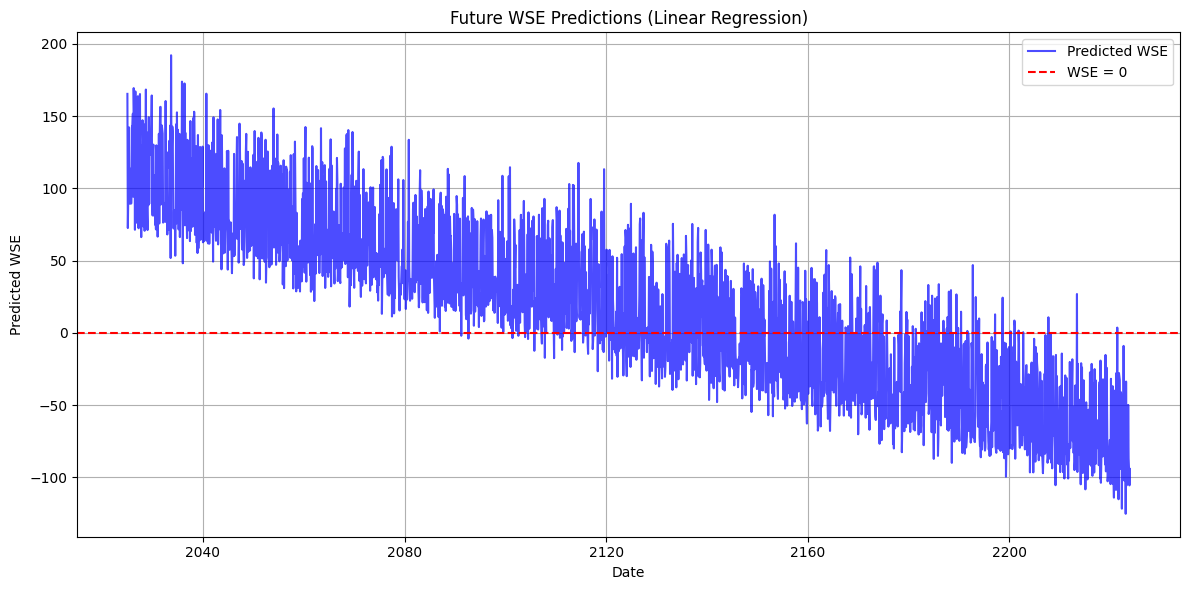

In [ ]:
future_dates = pd.date_range(
    start=f"{future_years.start}-01-01",
    end=f"{future_years.stop - 1}-12-31",
    freq='MS'  # Month Start frequency
)

# future_dates has to align with future_ppredictions
assert len(future_dates) == len(future_predictions), "Mismatch in x and y dimensions."

plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label="Predicted WSE", color='blue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label="WSE = 0")  # Highlight WSE = 0
plt.xlabel("Date")
plt.ylabel("Predicted WSE")
plt.title("Future WSE Predictions (Linear Regression)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

This is both excellent and horrifying at the same time. Now, since negative WSEs don't really make sense, we're going to do some masking to make 0 the minimum:

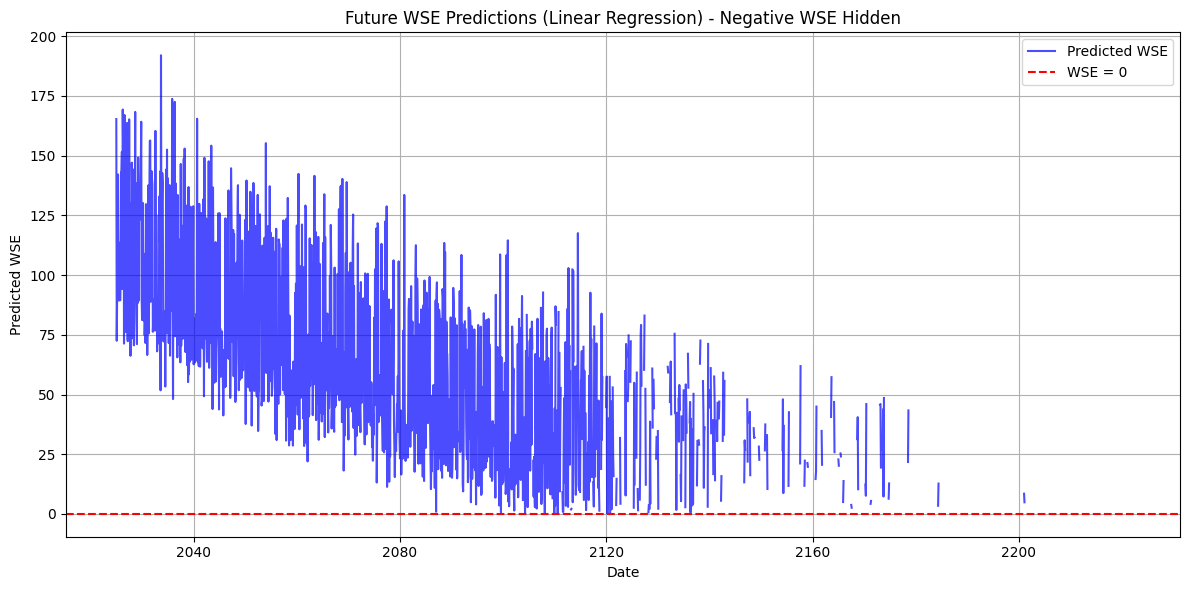

In [ ]:
# Mask negative WSE values
masked_predictions = np.where(future_predictions > 0, future_predictions, np.nan)

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(future_dates, masked_predictions, label="Predicted WSE", color='blue', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', label="WSE = 0")  # Highlight WSE = 0
plt.xlabel("Date")
plt.ylabel("Predicted WSE")
plt.title("California Water Surface Elevation - 200 Years From Now")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
first_zero_index = np.where(future_predictions <= 0)[0]
last_zero_index = np.where(future_predictions <= 0)[-1]

first_zero_index = first_zero_index[0]
first_zero_date = future_dates[first_zero_index]
print(f"The first predicted WSE reaches 0 or less on: {first_zero_date.strftime('%Y-%m-%d')}")

last_zero_index = last_zero_index[-1]
last_zero_date = future_dates[last_zero_index]
print(f"The last predicted WSE reaches 0 or less on: {last_zero_date.strftime('%Y-%m-%d')}")

The first predicted WSE reaches 0 or less on: 2091-04-01
The last predicted WSE reaches 0 or less on: 2223-12-01
